# GAN: Generative Adversarial Networks

In [2]:
import time
import torch
import torch.nn as nn

from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image

import matplotlib.pyplot as plt

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
latent_dim = 100

# 생성자(Generator) 클래스 정의
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        # 하나의 블록(block) 정의
        def block(input_dim, output_dim, normalize=True):
            layers = [nn.Linear(input_dim, output_dim)]
            if normalize:
                # 배치 정규화(batch normalization) 수행(차원 동일)
                layers.append(nn.BatchNorm1d(output_dim, 0.8))
            layers.append(nn.LeakyReLU(0.1, inplace=True))
            return layers

        # 생성자 모델은 연속적인 여러 개의 블록을 가짐
        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=True),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, 1 * 28 * 28),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), 1, 28, 28)
        return img

In [5]:
# 판별자(Discriminator) 클래스 정의
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        # MLP 형태
        self.model = nn.Sequential(
            nn.Linear(1 * 28 * 28, 512),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    # 이미지에 대한 판별 결과를 반환
    def forward(self, img):
        flattened = img.view(img.size(0), -1)
        output = self.model(flattened)

        return output

In [6]:
class MNIST_DataSet(torch.utils.data.Dataset):
    # 인자를 받아 인스턴스 변수를 초기화 
    # image_list - 이미지 전체 리스트
    def __init__(self, image_list, transform=None):
        super().__init__()
        self.image_list = image_list
        self.transform = transform

    # 데이터 셋의 길이를 리턴한다.
    def __len__(self):
        return len(self.image_list)
    
    # 학습 이미지를 리턴한다.
    def __getitem__(self, idx):
        image = self.image_list[idx]

        if self.transform:
          image = self.transform(image)

        return image

In [7]:
transform = transforms.Compose([transforms.ToTensor(),                                
                                transforms.Resize(28),
                                transforms.Normalize([0.5], [0.5])])

# GAN은 Test용 Dataset을 별도로 받을 필요가 없음
train_dataset = datasets.MNIST(root="./dataset", 
                               train=True, 
                               download=True,
                               transform=transform)

train = MNIST_DataSet(train_dataset.data.numpy(), transform=transform)

imageloader = torch.utils.data.DataLoader(train, 
                                          batch_size=1024, 
                                          shuffle=True, 
                                          num_workers=2)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/train-images-idx3-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/train-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



In [8]:
class Trainer(nn.Module):
  def __init__(self, generator, discriminator, imageloader, latent_dim=100, lr=0.0002, device="cpu"):
    super().__init__()

    # 생성자(generator)와 판별자(discriminator) 초기화
    self.generator = generator
    self.discriminator = discriminator

    self.imageloader = imageloader

    # 손실 함수(loss function) : Binary Cross Entropy Loss ( 진짜, 가짜 판별 : 이진 분류 )
    self.loss = nn.BCELoss()

    # 생성자와 판별자를 위한 최적화 함수
    self.optimizer_G = torch.optim.Adam(self.generator.parameters(), lr=lr, betas=(0.5, 0.999))
    self.optimizer_D = torch.optim.Adam(self.discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

    self.latent_dim = latent_dim
    self.device = device
    self.lr = lr

  def plot_images(self):
    images = self.generator(torch.normal(mean=0, std=1, size=(25, self.latent_dim)).to(self.device)).cpu().detach()
    fig = plt.figure(figsize=(20, 20))

    for idx, image in enumerate(images):
        # 1, 28, 28 => 28, 28
        image = torch.squeeze(image)
        ax = fig.add_subplot(5, 5, idx+1)
        ax.imshow(image)

    fig.show()

  def history(self, hist, max_epochs):
    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(2, 1, 1)
    ax.plot(range(1, max_epochs+1), hist['Discriminator_Loss'], color="red", label="d loss")
    ax.set_title("Discriminator Loss")
    ax.legend()

    ax = fig.add_subplot(2, 1, 2)
    ax.plot(range(1, max_epochs+1), hist['Generator_Loss'], color="blue", label="g loss")
    ax.set_title("Generator Loss")
    ax.legend()

    fig.show()

  def train(self, max_epochs=200):
    print("==== Train Start ====")
    start_time = time.time()
    hist = {"Generator_Loss":[], "Discriminator_Loss":[]}

    for epoch in range(max_epochs):
      g_loss, d_loss = self._train_epoch()

      hist["Generator_Loss"].append(g_loss)
      hist["Discriminator_Loss"].append(d_loss)

      #if epoch % 10 == 0:
      #  self.plot_images()

      print(f"[Epoch {epoch + 1}/{max_epochs}] [D loss: {d_loss:.6f}] [G loss: {g_loss:.6f}] [Elapsed time: {time.time() - start_time:.2f}s]")
    
    self.history(hist, max_epochs)

  def _train_epoch(self):
    for i, imgs in enumerate(self.imageloader):
      # 진짜(real) 이미지와 가짜(fake) 이미지에 대한 정답 레이블 생성 (cuda로)
      real = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(1.0) # 진짜(real): 1
      fake = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(0.0) # 가짜(fake): 0

      real_imgs = imgs.to(self.device)

      # ======= Generator 학습 영역 ==========
      self.optimizer_G.zero_grad()

      # 랜덤 노이즈(noise) 샘플링 (device로)
      z = torch.normal(mean=0, std=1, size=(imgs.shape[0], self.latent_dim)).to(self.device)

      # 이미지 생성
      generated_imgs = self.generator(z)

      # 생성자(generator)의 손실(loss) 값 계산
      self.g_loss = self.loss(self.discriminator(generated_imgs), real)

      # 생성자(generator) 업데이트
      self.g_loss.backward()
      self.optimizer_G.step()

      # ======= Discriminator 학습 영역 ==========
      self.optimizer_D.zero_grad()

      # 판별자(discriminator)의 손실(loss) 값 계산
      real_loss = self.loss(self.discriminator(real_imgs), real)
      fake_loss = self.loss(self.discriminator(generated_imgs.detach()), fake)
      self.d_loss = (real_loss + fake_loss) / 2

      # 판별자(discriminator) 업데이트
      self.d_loss.backward()
      self.optimizer_D.step()

    return self.g_loss.item(), self.d_loss.item()

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[Epoch 1/5000] [D loss: 0.529496] [G loss: 0.649081] [Elapsed time: 2.51s]
[Epoch 2/5000] [D loss: 0.542151] [G loss: 0.753835] [Elapsed time: 4.94s]
[Epoch 3/5000] [D loss: 0.528967] [G loss: 0.685419] [Elapsed time: 7.36s]
[Epoch 4/5000] [D loss: 0.501429] [G loss: 0.604135] [Elapsed time: 9.79s]
[Epoch 5/5000] [D loss: 0.501336] [G loss: 0.622712] [Elapsed time: 12.26s]
[Epoch 6/5000] [D loss: 0.540021] [G loss: 1.377921] [Elapsed time: 14.64s]
[Epoch 7/5000] [D loss: 0.591096] [G loss: 0.443967] [Elapsed time: 17.03s]
[Epoch 8/5000] [D loss: 0.418982] [G loss: 1.455161] [Elapsed time: 19.38s]
[Epoch 9/5000] [D loss: 0.494310] [G loss: 1.451007] [Elapsed time: 21.80s]
[Epoch 10/5000] [D loss: 0.331196] [G loss: 1.471859] [Elapsed time: 24.15s]
[Epoch 11/5000] [D loss: 0.492019] [G loss: 0.884585] [Elapsed time: 26.53s]
[Epoch 12/5000] [D loss: 0.434472] [G loss: 1.132005] [Elapsed time: 28.98s]
[Epoch 13/5000] [D loss: 0.503632] [G loss: 0.586422]

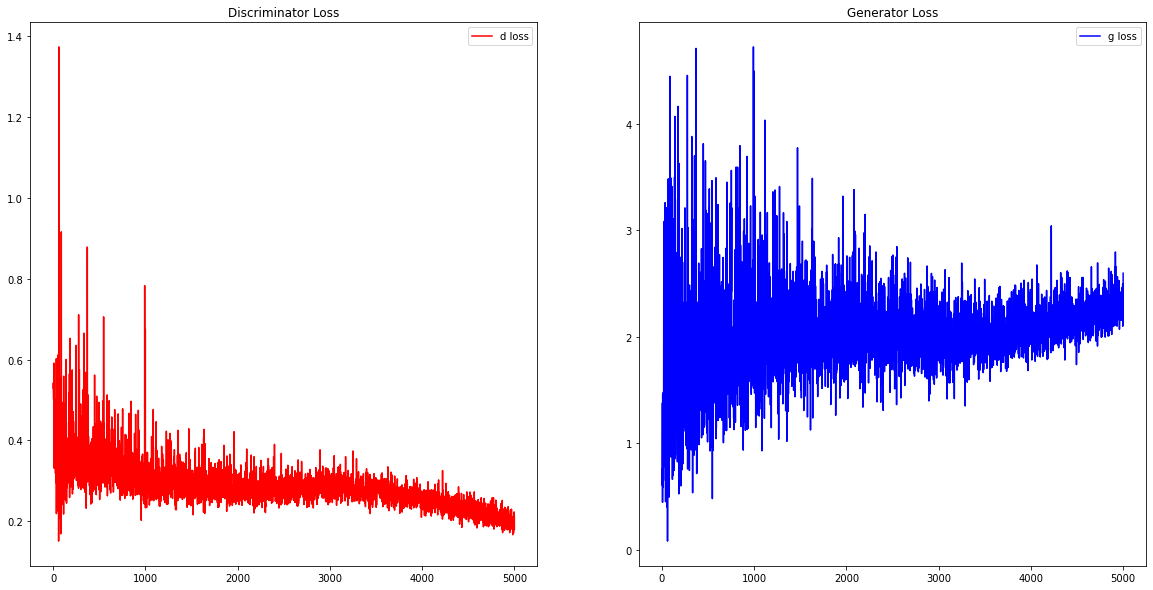

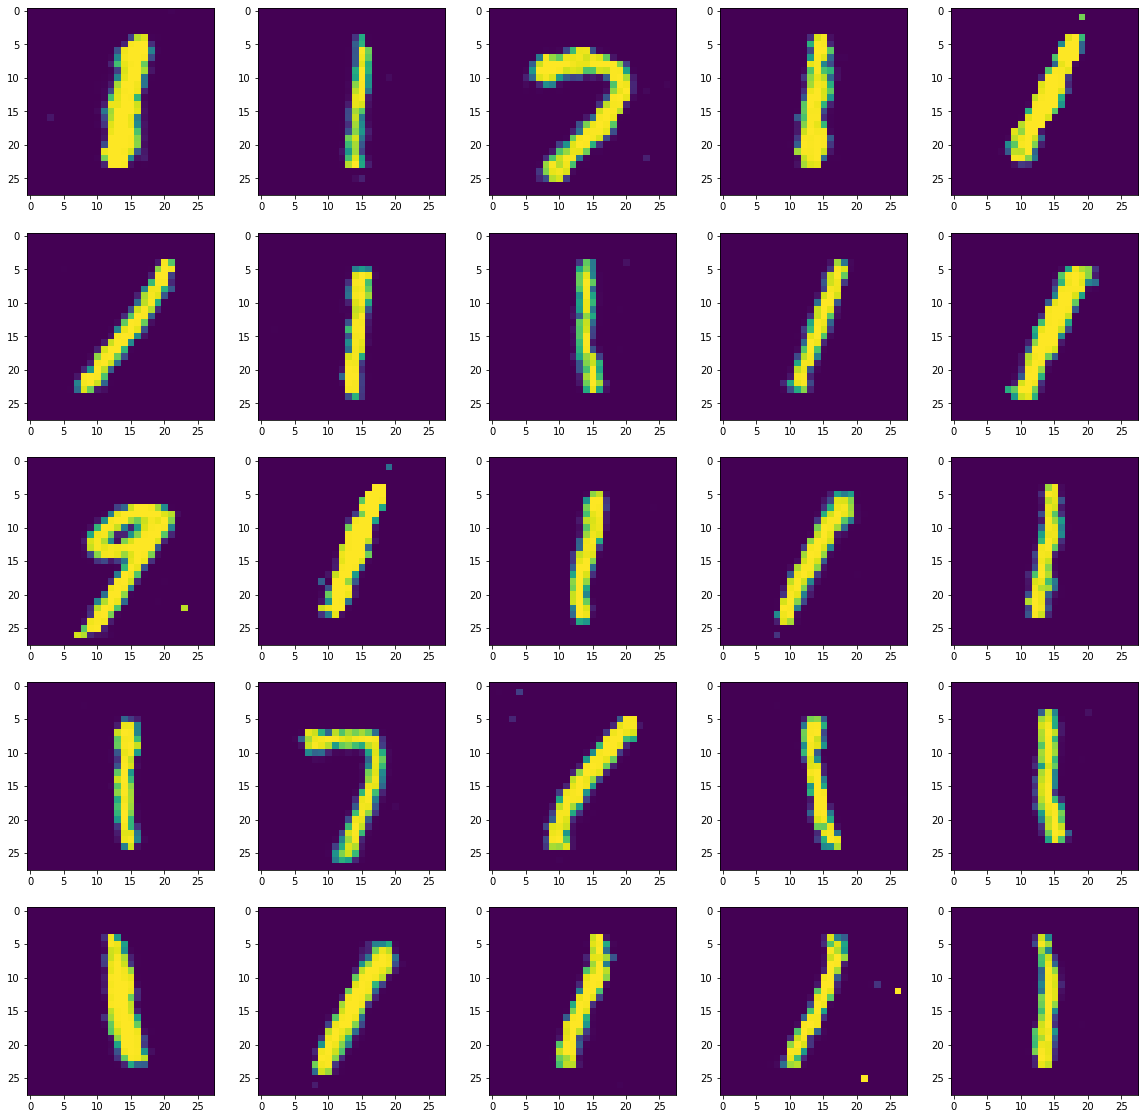

In [9]:
trainer = Trainer(generator=Generator().to(device),
                  discriminator=Discriminator().to(device),
                  imageloader=imageloader,
                  device=device)

trainer.train(max_epochs=5000)
trainer.plot_images()

In [10]:
trainer.generator

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace=True)
    (3): Linear(in_features=128, out_features=256, bias=True)
    (4): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.1, inplace=True)
    (6): Linear(in_features=256, out_features=512, bias=True)
    (7): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.1, inplace=True)
    (9): Linear(in_features=512, out_features=1024, bias=True)
    (10): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.1, inplace=True)
    (12): Linear(in_features=1024, out_features=784, bias=True)
    (13): Tanh()
  )
)

In [11]:
trainer.discriminator

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.1, inplace=True)
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)